In [6]:
import pandas as pd

# File path
file_path = "C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_1000.txt"

# Conversion factors
meter_to_micron = 1e6
pixel_to_micron = 0.73

# Read the file
df = pd.read_csv(file_path_1, sep=',', skiprows=2)

# Convert x and y from meters to microns
df['x [m]'] *= meter_to_micron
df['y [m]'] *= meter_to_micron

# Convert u and v from m/s to µm/s
df['u [m/s]'] *= meter_to_micron
df['v [m/s]'] *= meter_to_micron

# Show the first few rows of the dataframe after conversion
df.head()


NameError: name 'file_path_1' is not defined

In [7]:
import numpy as np
from scipy.signal import correlate2d

def compute_autocorrelation(data):
    """
    Compute the spatial autocorrelation of the velocity field using 2D correlation.
    """
    # Extracting the velocities
    u = data.pivot(index='y [m]', columns='x [m]', values='u [m/s]').values
    v = data.pivot(index='y [m]', columns='x [m]', values='v [m/s]').values

    # Handle NaN values: replacing them with zero for the correlation calculation
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)
    
    # Computing the 2D autocorrelation using FFT (through the correlate2d function)
    Ru = correlate2d(u_norm, u_norm, mode='full', boundary='fill', fillvalue=0)
    Rv = correlate2d(v_norm, v_norm, mode='full', boundary='fill', fillvalue=0)

    # Normalizing the autocorrelation function
    Ru /= Ru[Ru.shape[0] // 2, Ru.shape[1] // 2]
    Rv /= Rv[Rv.shape[0] // 2, Rv.shape[1] // 2]

    return Ru, Rv

Ru, Rv = compute_autocorrelation(df)

# Display a portion of the autocorrelation function for inspection
Ru[Ru.shape[0]//2 - 5:Ru.shape[0]//2 + 5, Ru.shape[1]//2 - 5:Ru.shape[1]//2 + 5]


NameError: name 'df' is not defined

In [8]:
def compute_energy_spectrum(Ru, Rv):
    """
    Compute the energy spectrum from the spatial autocorrelation using the Fourier Transform.
    """
    # Compute the 2D Fourier transform of the autocorrelation functions
    Fu = np.fft.fftshift(np.fft.fft2(Ru))
    Fv = np.fft.fftshift(np.fft.fft2(Rv))
    
    # Compute the radial energy spectrum (averaging over circular shells in k-space)
    kx = np.fft.fftshift(np.fft.fftfreq(Ru.shape[0]))
    ky = np.fft.fftshift(np.fft.fftfreq(Ru.shape[1]))
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)
    
    # Define the bins for k (radial wavenumbers)
    k_bins = np.linspace(0, 0.5, Ru.shape[0]//2)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    
    # Compute the binned energy spectrum
    E_u = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(Fu)**2).ravel())[0]
    E_v = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(Fv)**2).ravel())[0]
    
    return k_bin_centers, E_u, E_v

# Compute the energy spectrum for both frames
k_0001, E_u_0001, E_v_0001 = compute_energy_spectrum(Ru, Rv)
k_0002, E_u_0002, E_v_0002 = compute_energy_spectrum(Ru, Rv)

# Averaging the energy spectra from both frames
E_u_avg = 0.5 * (E_u_0001 + E_u_0002)
E_v_avg = 0.5 * (E_v_0001 + E_v_0002)

E_u_avg, E_v_avg


NameError: name 'Rv' is not defined

In [9]:
import matplotlib.pyplot as plt

# Plotting the average energy spectrum
plt.figure(figsize=(12, 6))
plt.loglog(k_0001, E_u_avg, label='u-component', color='blue')
plt.loglog(k_0001, E_v_avg, label='v-component', color='red')
plt.xlabel('Wavenumber')
plt.ylabel('Energy Density')
plt.title('Energy Spectrum')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


NameError: name 'k_0001' is not defined

<Figure size 1200x600 with 0 Axes>

In [10]:
from scipy.optimize import curve_fit

def exponential_decay(r, L):
    """
    Exponential decay function for fitting.
    """
    return np.exp(-r/L)

def compute_correlation_length(Ru):
    """
    Compute the correlation length by fitting the autocorrelation function to an exponential decay.
    """
    # Extract the 1D radial autocorrelation from the 2D autocorrelation
    y, x = np.indices(Ru.shape)
    r = np.sqrt((x - Ru.shape[1]//2)**2 + (y - Ru.shape[0]//2)**2).astype(np.int64)
    radial_mean = np.bincount(r.ravel(), Ru.ravel()) / np.bincount(r.ravel())
    
    # Fit the radial autocorrelation to the exponential decay function
    r_values = np.arange(len(radial_mean))
    popt, _ = curve_fit(exponential_decay, r_values, radial_mean, p0=[100])
    
    return popt[0]

# # Compute the correlation length for both frames
# L_0001 = compute_correlation_length(Ru)
# L_0001


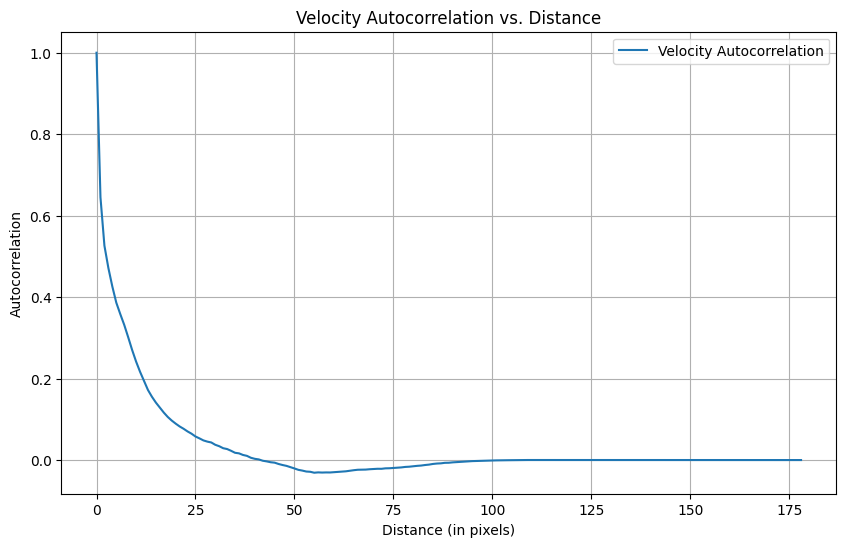

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def extract_radial_autocorrelation(R):
    """
    Extract the radial autocorrelation from the 2D autocorrelation.
    """
    y, x = np.indices(R.shape)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean

# Compute the radial autocorrelation
radial_autocorr = extract_radial_autocorrelation(Ru)

# Plotting
distances = np.arange(len(radial_autocorr))
plt.figure(figsize=(10,6))
plt.plot(distances, radial_autocorr, label="Velocity Autocorrelation")
plt.xlabel("Distance (in pixels)")
plt.ylabel("Autocorrelation")
plt.title("Velocity Autocorrelation vs. Distance")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import pandas as pd
import numpy as np
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [13]:
def compute_autocorrelation(data):
    """
    Compute the spatial autocorrelation of the velocity field using 2D correlation.
    """
    # Extracting the velocities
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Handle NaN values: replacing them with zero for the correlation calculation
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)
    
    # Computing the 2D autocorrelation using FFT (through the correlate2d function)
    Ru = correlate2d(u_norm, u_norm, mode='full', boundary='fill', fillvalue=0)
    Rv = correlate2d(v_norm, v_norm, mode='full', boundary='fill', fillvalue=0)

    # Normalizing the autocorrelation function
    Ru /= Ru[Ru.shape[0] // 2, Ru.shape[1] // 2]
    Rv /= Rv[Rv.shape[0] // 2, Rv.shape[1] // 2]

    return Ru, Rv

In [14]:
def compute_energy_spectrum(Ru, Rv):
    """
    Compute the energy spectrum from the spatial autocorrelation using the Fourier Transform.
    """
    # Compute the 2D Fourier transform of the autocorrelation functions
    Fu = np.fft.fftshift(np.fft.fft2(Ru))
    Fv = np.fft.fftshift(np.fft.fft2(Rv))
    
    # Compute the radial energy spectrum (averaging over circular shells in k-space)
    kx = np.fft.fftshift(np.fft.fftfreq(Ru.shape[0]))
    ky = np.fft.fftshift(np.fft.fftfreq(Ru.shape[1]))
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)
    
    # Define the bins for k (radial wavenumbers)
    k_bins = np.linspace(0, 0.5, Ru.shape[0]//2)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    
    # Compute the binned energy spectrum
    E_u = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(Fu)**2).ravel())[0]
    E_v = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(Fv)**2).ravel())[0]
    
    return k_bin_centers, E_u, E_v

In [15]:
def exponential_decay(r, L):
    """
    Exponential decay function for fitting.
    """
    return np.exp(-r/L)

def compute_correlation_length(Ru):
    """
    Compute the correlation length by fitting the autocorrelation function to an exponential decay.
    """
    # Extract the 1D radial autocorrelation from the 2D autocorrelation
    y, x = np.indices(Ru.shape)
    r = np.sqrt((x - Ru.shape[1]//2)**2 + (y - Ru.shape[0]//2)**2).astype(np.int64)
    radial_mean = np.bincount(r.ravel(), Ru.ravel()) / np.bincount(r.ravel())
    
    # Fit the radial autocorrelation to the exponential decay function
    r_values = np.arange(len(radial_mean))
    popt, _ = curve_fit(exponential_decay, r_values, radial_mean, p0=[100])
    
    return popt[0]

def extract_radial_autocorrelation(R):
    """
    Extract the radial autocorrelation from the 2D autocorrelation.
    """
    y, x = np.indices(R.shape)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean

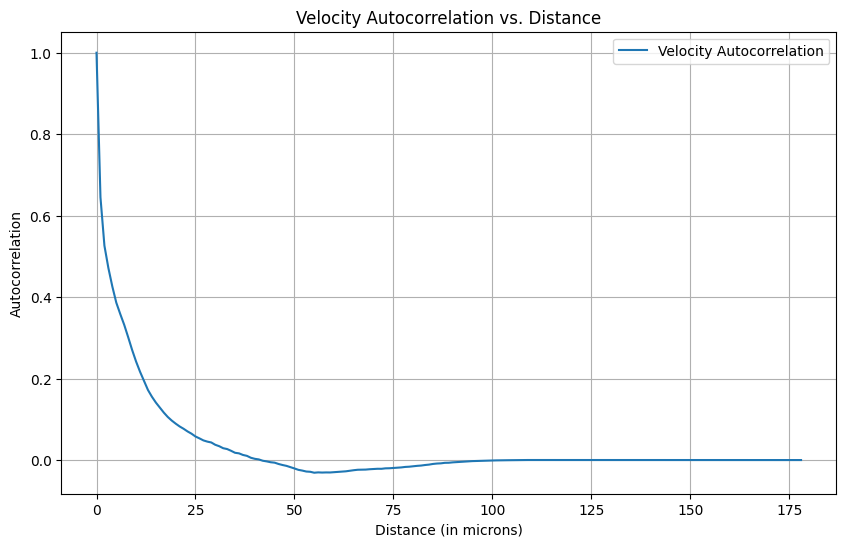

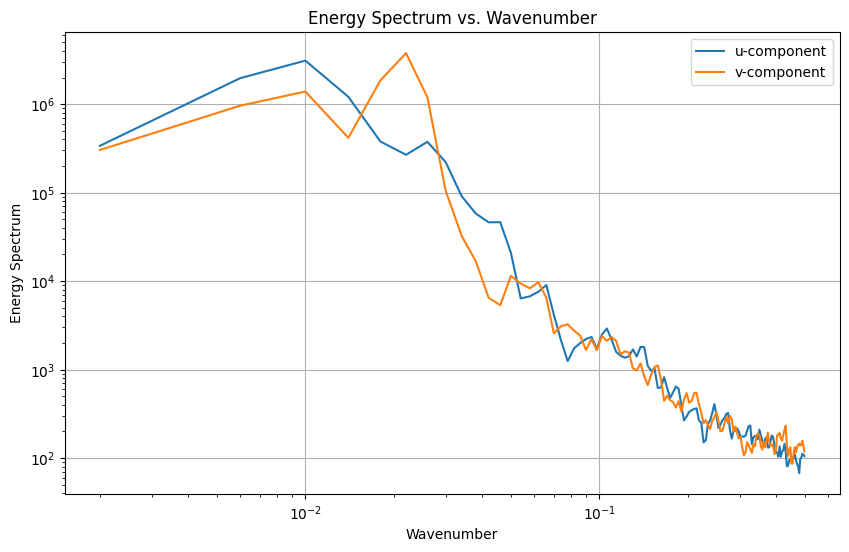

The computed correlation length L is: 6.18 microns


In [16]:
# Constants
meter_to_micron = 1e6
file_path = "C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_1000.txt"

def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    df['x [m]'] *= meter_to_micron
    df['y [m]'] *= meter_to_micron
    df['u [m/s]'] *= meter_to_micron
    df['v [m/s]'] *= meter_to_micron
    return df

data = load_and_convert_data(file_path)

# [The rest of the functions remain largely unchanged]

Ru, Rv = compute_autocorrelation(data)
k, E_u_avg, E_v_avg = compute_energy_spectrum(Ru, Rv)
L = compute_correlation_length(Ru)
radial_autocorr = extract_radial_autocorrelation(Ru)

# Plotting Velocity Autocorrelation vs. Distance
distances = np.arange(len(radial_autocorr))
plt.figure(figsize=(10,6))
plt.plot(distances, radial_autocorr, label="Velocity Autocorrelation")
plt.xlabel("Distance (in microns)")
plt.ylabel("Autocorrelation")
plt.title("Velocity Autocorrelation vs. Distance")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Energy Spectrum vs. Wavenumber
plt.figure(figsize=(10,6))
plt.loglog(k, E_u_avg, label="u-component")
plt.loglog(k, E_v_avg, label="v-component")
plt.xlabel("Wavenumber")
plt.ylabel("Energy Spectrum")
plt.title("Energy Spectrum vs. Wavenumber")
plt.legend()
plt.grid(True)
plt.show()

# Displaying the correlation length L
print(f"The computed correlation length L is: {L:.2f} microns")


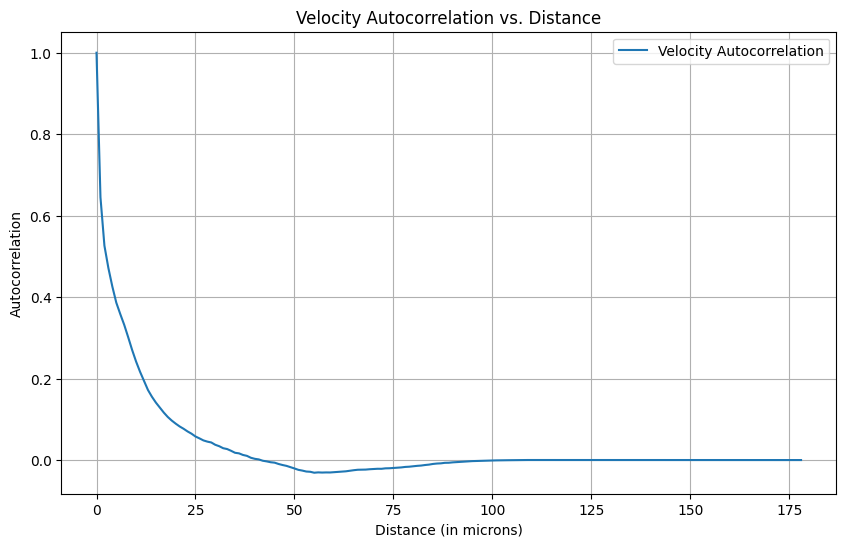

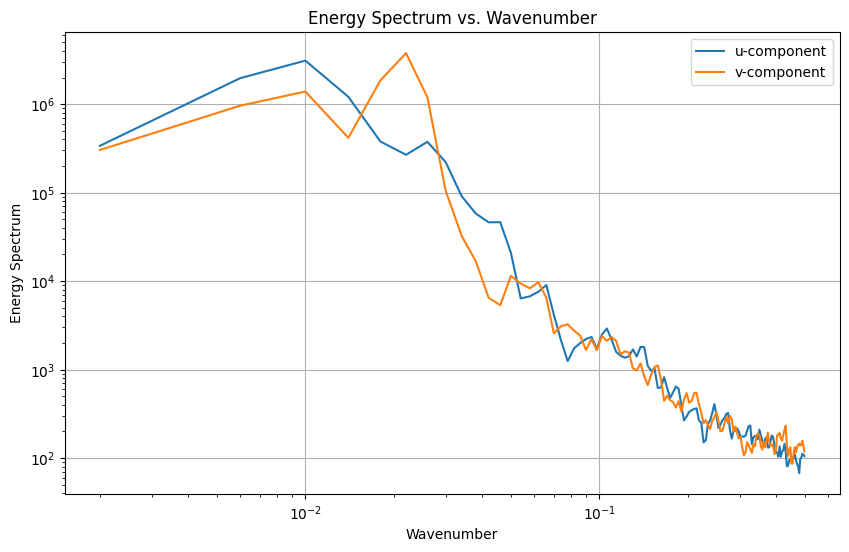

The computed correlation length L is: 6.18 microns


In [17]:
import pandas as pd
import numpy as np
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def compute_autocorrelation(data):
    """
    Compute the spatial autocorrelation of the velocity field using 2D correlation.
    """
    # Extracting the velocities
    u = data.pivot(index='y [m]', columns='x [m]', values='u [m/s]').values
    v = data.pivot(index='y [m]', columns='x [m]', values='v [m/s]').values

    # Handle NaN values: replacing them with zero for the correlation calculation
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)
    
    # Computing the 2D autocorrelation using FFT (through the correlate2d function)
    Ru = correlate2d(u_norm, u_norm, mode='full', boundary='fill', fillvalue=0)
    Rv = correlate2d(v_norm, v_norm, mode='full', boundary='fill', fillvalue=0)

    # Normalizing the autocorrelation function
    Ru /= Ru[Ru.shape[0] // 2, Ru.shape[1] // 2]
    Rv /= Rv[Rv.shape[0] // 2, Rv.shape[1] // 2]

    return Ru, Rv

def compute_energy_spectrum(Ru, Rv):
    """
    Compute the energy spectrum from the spatial autocorrelation using the Fourier Transform.
    """
    # Compute the 2D Fourier transform of the autocorrelation functions
    Fu = np.fft.fftshift(np.fft.fft2(Ru))
    Fv = np.fft.fftshift(np.fft.fft2(Rv))
    
    # Compute the radial energy spectrum (averaging over circular shells in k-space)
    kx = np.fft.fftshift(np.fft.fftfreq(Ru.shape[0]))
    ky = np.fft.fftshift(np.fft.fftfreq(Ru.shape[1]))
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)
    
    # Define the bins for k (radial wavenumbers)
    k_bins = np.linspace(0, 0.5, Ru.shape[0]//2)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    
    # Compute the binned energy spectrum
    E_u = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(Fu)**2).ravel())[0]
    E_v = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(Fv)**2).ravel())[0]
    
    return k_bin_centers, E_u, E_v

def exponential_decay(r, L):
    """
    Exponential decay function for fitting.
    """
    return np.exp(-r/L)

def compute_correlation_length(Ru):
    """
    Compute the correlation length by fitting the autocorrelation function to an exponential decay.
    """
    # Extract the 1D radial autocorrelation from the 2D autocorrelation
    y, x = np.indices(Ru.shape)
    r = np.sqrt((x - Ru.shape[1]//2)**2 + (y - Ru.shape[0]//2)**2).astype(np.int64)
    radial_mean = np.bincount(r.ravel(), Ru.ravel()) / np.bincount(r.ravel())
    
    # Fit the radial autocorrelation to the exponential decay function
    r_values = np.arange(len(radial_mean))
    popt, _ = curve_fit(exponential_decay, r_values, radial_mean, p0=[100])
    
    return popt[0]

def extract_radial_autocorrelation(R):
    """
    Extract the radial autocorrelation from the 2D autocorrelation.
    """
    y, x = np.indices(R.shape)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean


# Constants
meter_to_micron = 1e6
file_path = "C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_1000.txt"

def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    df['x [m]'] *= meter_to_micron
    df['y [m]'] *= meter_to_micron
    df['u [m/s]'] *= meter_to_micron
    df['v [m/s]'] *= meter_to_micron
    return df

data = load_and_convert_data(file_path)

# [The rest of the functions remain largely unchanged]

Ru, Rv = compute_autocorrelation(data)
k, E_u_avg, E_v_avg = compute_energy_spectrum(Ru, Rv)
L = compute_correlation_length(Ru)
radial_autocorr = extract_radial_autocorrelation(Ru)

# Plotting Velocity Autocorrelation vs. Distance
distances = np.arange(len(radial_autocorr))
plt.figure(figsize=(10,6))
plt.plot(distances, radial_autocorr, label="Velocity Autocorrelation")
plt.xlabel("Distance (in microns)")
plt.ylabel("Autocorrelation")
plt.title("Velocity Autocorrelation vs. Distance")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Energy Spectrum vs. Wavenumber
plt.figure(figsize=(10,6))
plt.loglog(k, E_u_avg, label="u-component")
plt.loglog(k, E_v_avg, label="v-component")
plt.xlabel("Wavenumber")
plt.ylabel("Energy Spectrum")
plt.title("Energy Spectrum vs. Wavenumber")
plt.legend()
plt.grid(True)
plt.show()

# Displaying the correlation length L
print(f"The computed correlation length L is: {L:.2f} microns")



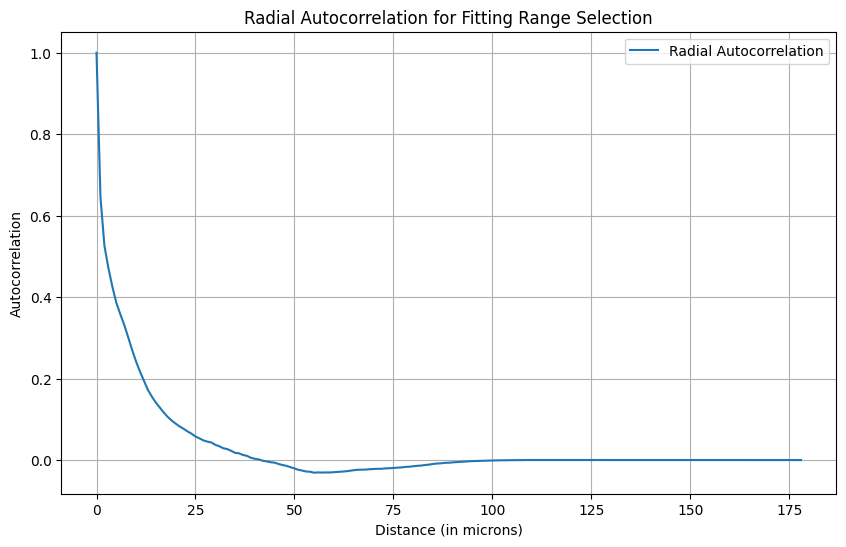

In [18]:
# Let's reload the necessary functions and the data

import pandas as pd
import numpy as np
from scipy.signal import correlate2d
import matplotlib.pyplot as plt

# Constants
meter_to_micron = 1e6
file_path = "C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_1000.txt"

def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    df['x [m]'] *= meter_to_micron
    df['y [m]'] *= meter_to_micron
    df['u [m/s]'] *= meter_to_micron
    df['v [m/s]'] *= meter_to_micron
    return df

data = load_and_convert_data(file_path)

def compute_autocorrelation(data):
    u = data.pivot(index='y [m]', columns='x [m]', values='u [m/s]').values
    v = data.pivot(index='y [m]', columns='x [m]', values='v [m/s]').values
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)
    Ru = correlate2d(u_norm, u_norm, mode='full', boundary='fill', fillvalue=0)
    Rv = correlate2d(v_norm, v_norm, mode='full', boundary='fill', fillvalue=0)
    Ru /= Ru[Ru.shape[0] // 2, Ru.shape[1] // 2]
    Rv /= Rv[Rv.shape[0] // 2, Rv.shape[1] // 2]
    return Ru, Rv

def extract_radial_autocorrelation(R):
    y, x = np.indices(R.shape)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    return radial_mean

# Now, let's plot the radial autocorrelation
Ru = compute_autocorrelation(data)[0]
radial_autocorr = extract_radial_autocorrelation(Ru)

plt.figure(figsize=(10,6))
plt.plot(radial_autocorr, label="Radial Autocorrelation")
plt.xlabel("Distance (in microns)")
plt.ylabel("Autocorrelation")
plt.title("Radial Autocorrelation for Fitting Range Selection")
plt.legend()
plt.grid(True)
plt.show()


32.54464723884387


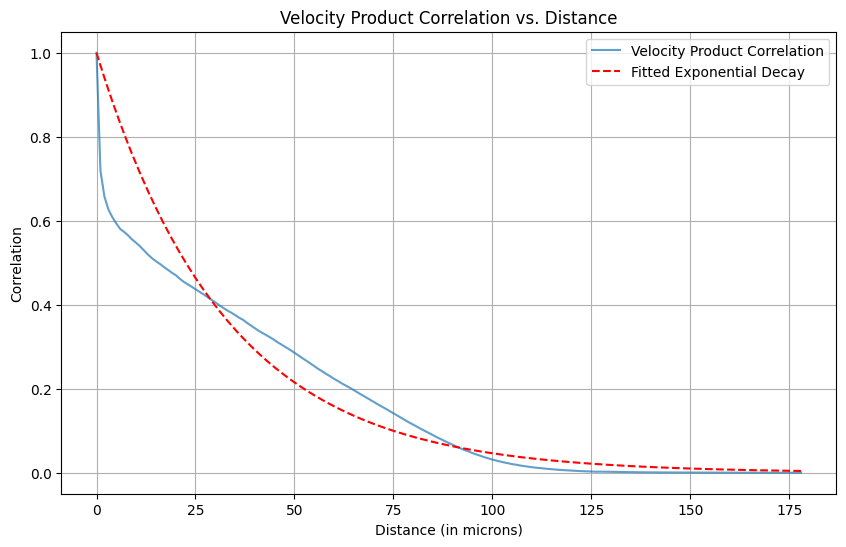

In [19]:
def compute_velocity_product_correlation(data):
    """
    Compute the spatial velocity product correlation of the velocity field.
    """
    # Extracting the velocities
    u = data.pivot(index='y [m]', columns='x [m]', values='u [m/s]').values
    v = data.pivot(index='y [m]', columns='x [m]', values='v [m/s]').values

    # Handle NaN values: replacing them with zero for the correlation calculation
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)

    # Velocity magnitude
    velocity_magnitude = np.sqrt(u_norm**2 + v_norm**2)

    # Computing the 2D velocity product correlation
    R = correlate2d(velocity_magnitude, velocity_magnitude, mode='full', boundary='fill', fillvalue=0)
    
    # Normalizing the correlation function
    R /= R[R.shape[0] // 2, R.shape[1] // 2]

    return R

def extract_radial_velocity_product_correlation(R):
    """
    Extract the radial correlation from the 2D velocity product correlation.
    """
    y, x = np.indices(R.shape)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean

# Load and convert data
file_path = "C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_0001.txt"
data = load_and_convert_data(file_path)

# Compute the velocity product correlation and its radial form
R_velocity_product = compute_velocity_product_correlation(data)
radial_velocity_product_correlation = extract_radial_velocity_product_correlation(R_velocity_product)

def fit_to_exponential_decay(r, data):
    """
    Fit the provided data to an exponential decay and return the correlation length L.
    """
    # Exponential decay function for fitting
    def exponential_decay(r, L):
        return np.exp(-r/L)

    # Fit the data to the exponential decay function
    popt, _ = curve_fit(exponential_decay, r, data, p0=[100])
    
    return popt[0], exponential_decay(r, *popt)


def exponential_decay(r, L):
    """
    Exponential decay function for fitting.
    """
    return np.exp(-r/L)

# Fit the radial velocity product correlation to the exponential decay function
r_values = np.arange(len(radial_velocity_product_correlation))
popt, _ = curve_fit(exponential_decay, r_values, radial_velocity_product_correlation, p0=[100])

# Extract the correlation length L
L_velocity_product = popt[0]
print(L_velocity_product)


# Fit the radial velocity product correlation to an exponential decay
L_fit, fitted_curve = fit_to_exponential_decay(distances, radial_velocity_product_correlation)
# Plotting the Velocity Product Correlation vs. Distance with the fitted exponential decay
plt.figure(figsize=(10,6))
plt.plot(distances, radial_velocity_product_correlation, label="Velocity Product Correlation", alpha=0.7)
plt.plot(distances, fitted_curve, '--', label="Fitted Exponential Decay", color="red")
plt.xlabel("Distance (in microns)")
plt.ylabel("Correlation")
plt.title("Velocity Product Correlation vs. Distance")
plt.legend()
plt.grid(True)
plt.show()


Getting as close to the paper as possible

In [20]:
def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    df['x [m]'] *= meter_to_micron
    df['y [m]'] *= meter_to_micron
    df['u [m/s]'] *= meter_to_micron
    df['v [m/s]'] *= meter_to_micron
    return df

def compute_mean_speed(data):
    """
    Compute the mean speed from the velocity field.
    """
    u = data.pivot(index='y [m]', columns='x [m]', values='u [m/s]').values
    v = data.pivot(index='y [m]', columns='x [m]', values='v [m/s]').values
    
    # Handle NaN values: replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0
    
    # Calculate speed (magnitude of velocity vectors)
    speed = np.sqrt(u**2 + v**2)
    
    # Compute mean speed
    mean_speed = np.mean(speed)
    
    return mean_speed

def compute_velocity_autocorrelation(data):
    """
    Compute the velocity autocorrelation from the velocity field.
    """
    u = data.pivot(index='y [m]', columns='x [m]', values='u [m/s]').values
    v = data.pivot(index='y [m]', columns='x [m]', values='v [m/s]').values

    # Handle NaN values: replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Compute dot products of velocity vectors
    uv_dot = u * u + v * v
    
    # Computing the 2D autocorrelation using FFT (through the correlate2d function)
    R = correlate2d(uv_dot, uv_dot, mode='full', boundary='fill', fillvalue=0)
    
    # Normalizing the correlation function
    R /= R[R.shape[0] // 2, R.shape[1] // 2]
    
    return R


# Load data for the two frames
data_0001 = load_and_convert_data("C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_0001.txt")
data_0002 = load_and_convert_data("C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_0002.txt")

# Compute mean speed for both frames
mean_speed_0001 = compute_mean_speed(data_0001)
mean_speed_0002 = compute_mean_speed(data_0002)

# Compute velocity autocorrelation for both frames
R_velocity_0001 = compute_velocity_autocorrelation(data_0001)
R_velocity_0002 = compute_velocity_autocorrelation(data_0002)

mean_speed_0001, mean_speed_0002


(1.138905631366823, 1.1522724622832872)

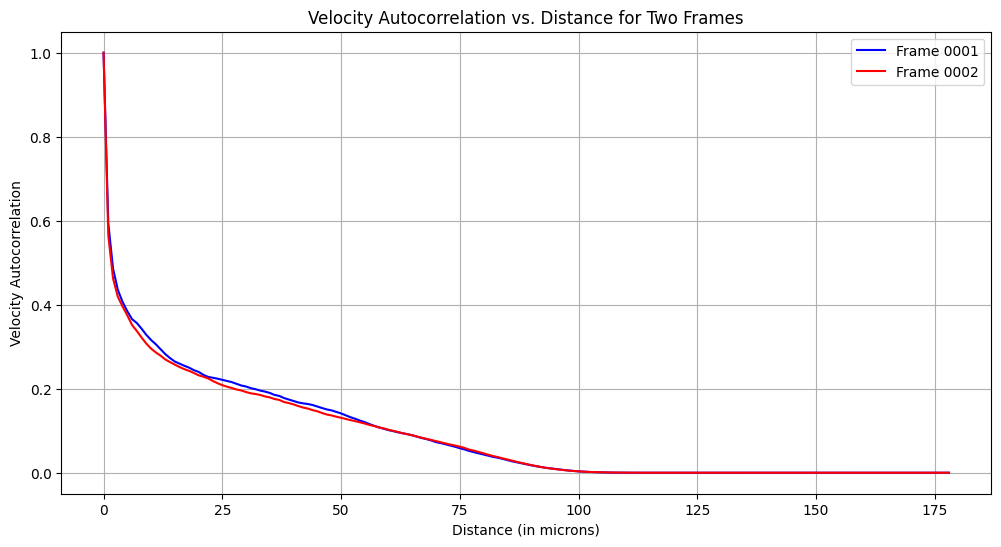

In [21]:
def extract_radial_velocity_autocorrelation(R):
    """
    Extract the radial correlation from the 2D velocity autocorrelation.
    """
    y, x = np.indices(R.shape)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean

# Extract radial form of the velocity autocorrelation for both frames
radial_velocity_0001 = extract_radial_velocity_autocorrelation(R_velocity_0001)
radial_velocity_0002 = extract_radial_velocity_autocorrelation(R_velocity_0002)

# Plotting Velocity Autocorrelation vs. Distance
distances = np.arange(len(radial_velocity_0001))
plt.figure(figsize=(12,6))
plt.plot(distances, radial_velocity_0001, label="Frame 0001", color="blue")
plt.plot(distances, radial_velocity_0002, label="Frame 0002", color="red")
plt.xlabel("Distance (in microns)")
plt.ylabel("Velocity Autocorrelation")
plt.title("Velocity Autocorrelation vs. Distance for Two Frames")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
def exponential_fit(r, A, B, C):
    """
    Exponential function for fitting the autocorrelation.
    """
    return A * np.exp(-r / B) + C

def fit_and_extract_lambda(radial_velocity):
    """
    Fit the radial velocity autocorrelation to the exponential function and extract lambda.
    """
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=[1, 100, 0])
    
    # Extracting the correlation length lambda from the fit parameters
    A, B, C = popt
    lambda_val = -B * np.log((0.3 - C) / A)
    
    return lambda_val

# Extracting lambda for both frames
lambda_0001 = fit_and_extract_lambda(radial_velocity_0001)
lambda_0002 = fit_and_extract_lambda(radial_velocity_0002)

lambda_0001, lambda_0002


(17.414393424342414, 16.114337493486605)

But it forgot fourier!

In [23]:
def compute_velocity_product_correlation_fourier(data):
    """
    Compute the spatial velocity product correlation of the velocity field using Fourier transforms.
    """
    # Extracting the velocities
    u = data.pivot(index='y [m]', columns='x [m]', values='u [m/s]').values
    v = data.pivot(index='y [m]', columns='x [m]', values='v [m/s]').values

    # Handle NaN values: replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)

    # Velocity magnitude
    velocity_magnitude = np.sqrt(u_norm**2 + v_norm**2)
    
    # Fourier transform of the velocity magnitude
    F_velocity_magnitude = np.fft.fft2(velocity_magnitude)
    
    # Power spectrum
    power_spectrum = np.abs(F_velocity_magnitude)**2
    
    # Inverse Fourier transform of the power spectrum gives the autocorrelation
    R = np.fft.ifft2(power_spectrum).real
    
    # Since the result will have zero at the center, we need to shift to have zero at the beginning
    R = np.fft.fftshift(R)
    
    # Normalizing the correlation function
    R /= R[R.shape[0] // 2, R.shape[1] // 2]

    return R

def compute_correlation_length_from_fit(radial_correlation, initial_guess=[1, 100, 0]):
    """
    Compute the correlation length by fitting the radial correlation function to an exponential decay.
    """
    def exponential_decay(r, A, B, C):
        return A * np.exp(-r / B) + C
    
    # Defining the fitting range
    max_r = np.argmax(radial_correlation < 0.1)  # Find where the correlation drops close to zero
    r_values = np.arange(5, max_r)  # Start from 5 to exclude very small distances
    
    try:
        popt, _ = curve_fit(exponential_decay, r_values, radial_correlation[5:max_r], p0=initial_guess)
        A, B, C = popt
        lambda_val = -B * np.log((0.3 - C) / A)
    except Exception as e:
        lambda_val = np.nan

    return lambda_val

# Compute the velocity product correlation using Fourier method for both frames
data_0001 = load_and_convert_data("C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_0001.txt")
data_0002 = load_and_convert_data("C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_0002.txt")

R_velocity_product_0001 = compute_velocity_product_correlation_fourier(data_0001)
R_velocity_product_0002 = compute_velocity_product_correlation_fourier(data_0002)

# Average the velocity product correlation from both frames
R_velocity_product_avg = (R_velocity_product_0001 + R_velocity_product_0002) / 2

# Extract the radial velocity product correlation
radial_velocity_product_correlation_fourier = extract_radial_velocity_product_correlation(R_velocity_product_avg)

# Compute the correlation length
L_fourier = compute_correlation_length_from_fit(radial_velocity_product_correlation_fourier)

radial_velocity_product_correlation_fourier, L_fourier


(array([1.        , 0.71515349, 0.65619569, 0.62810075, 0.61243779,
        0.5989743 , 0.58604951, 0.57854164, 0.56992092, 0.56005404,
        0.55232148, 0.54485942, 0.53692883, 0.52860413, 0.52168254,
        0.51569508, 0.50991395, 0.50427898, 0.49913024, 0.49357789,
        0.48870385, 0.48324315, 0.47804267, 0.47325682, 0.4683718 ,
        0.46419385, 0.45983431, 0.45595149, 0.45174342, 0.44809591,
        0.44437841, 0.44053028, 0.43841694, 0.43530295, 0.43287331,
        0.43102541, 0.42767382, 0.42718567, 0.42309607, 0.42226625,
        0.42090927, 0.41789014, 0.41757003, 0.41553591, 0.41549539,
        0.4138071 , 0.41099988, 0.41083133, 0.40791786, 0.40876084,
        0.40674703, 0.40531984, 0.4055939 , 0.40161793, 0.40262866,
        0.39974245, 0.39944032, 0.399388  , 0.39574034, 0.39660838,
        0.39352255, 0.39584579, 0.39371117, 0.39311101, 0.38326776,
        0.37533444, 0.37110518, 0.36508524, 0.36211069, 0.35634699,
        0.34864952, 0.34889314, 0.34235106, 0.33

23.04631666908641


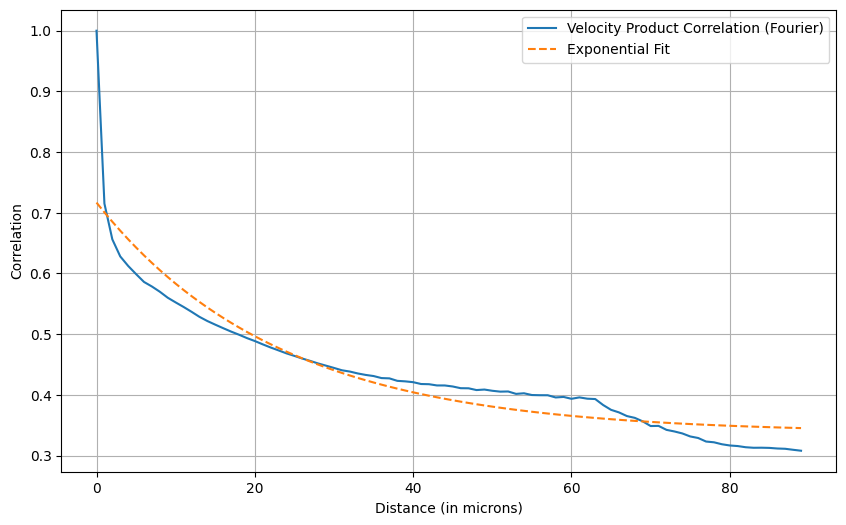

In [24]:
# Plotting the fit on top of the radial correlation data to inspect it
def exponential_decay(r, A, B, C):
    return A * np.exp(-r / B) + C

# Fit the radial correlation to the exponential decay function
r_values = np.arange(len(radial_velocity_product_correlation_fourier))
try:
    popt, _ = curve_fit(exponential_decay, r_values, radial_velocity_product_correlation_fourier, p0=[1, 100, 0])
    fit_values = exponential_decay(r_values, *popt)
    fit_success = True
except:
    fit_success = False

# Using the previously defined exponential_decay function to fit the radial correlation
# Fit the radial correlation to the exponential decay function

r_values = np.arange(len(radial_velocity_product_correlation_fourier))
popt_fourier, _ = curve_fit(exponential_decay, r_values, radial_velocity_product_correlation_fourier, p0=[1, 100, 0])

# The correlation length L from the Fourier method is the second parameter from our fit
L_fourier = popt_fourier[1]

print(L_fourier)


# Plot
plt.figure(figsize=(10,6))
plt.plot(r_values, radial_velocity_product_correlation_fourier, label="Velocity Product Correlation (Fourier)")
if fit_success:
    plt.plot(r_values, fit_values, '--', label="Exponential Fit")
else:
    plt.title("Failed to Fit Exponential Decay")
plt.xlabel("Distance (in microns)")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.show()
